In [121]:
import pandas as pd
import numpy as np

# function input0x input0y input1x input1y input2x input2y input3x input3y

op_dict = {0: '+', 1: '-', 2: '*', 3: '/'}

class Node:
    def __init__(self, x, y, function, input0x, input0y, input1x, input1y, input2x, input2y, input3x, input3y):
        self.x = x
        self.y = y
        self.function = function
        self.input0x = input0x
        self.input0y = input0y
        self.input1x = input1x
        self.input1y = input1y
        self.input2x = input2x
        self.input2y = input2y
        self.input3x = input3x
        self.input3y = input3y

    def __str__(self):
        op = op_dict.get(self.function, '?')
        return f"Node(({self.x}, {self.y}), function={op}, inputs=({self.input0x},{self.input0y}),({self.input1x},{self.input1y}),({self.input2x},{self.input2y}),({self.input3x},{self.input3y}))"

    def __repr__(self):
        return self.__str__()

def decode_nodes(arr):
    nodes = []
    # Loop over every 9 elements (each node has 9 values: 1 function + 8 input coordinates)
    for i in range(0, len(arr), 9):
        if i + 8 < len(arr):  # Ensure we have all 9 values
            function = arr[i]
            
            # Extract input coordinates (4 pairs: x,y for each input)
            input0x, input0y = arr[i+1], arr[i+2]
            input1x, input1y = arr[i+3], arr[i+4]
            input2x, input2y = arr[i+5], arr[i+6]
            input3x, input3y = arr[i+7], arr[i+8]
            
            node_index = i // 9
            total_nodes = len(arr) // 9
            # Calculate x, y coordinates based on grid arrangement
            grid_size = int(np.sqrt(total_nodes))
            x = node_index % grid_size
            y = node_index // grid_size
            
            # Create node object
            node = Node(x, y, function, input0x, input0y, input1x, input1y, 
                        input2x, input2y, input3x, input3y)
            
            nodes.append(node)
    
    return nodes

def generate_random_nodes(num_nodes=100):
    """Generate a random array representing nodes for decode_nodes function."""
    arr = []
    grid_size = int(np.sqrt(num_nodes))
    
    for i in range(num_nodes):
        # Random function (0-3 for +, -, *, /)
        function = np.random.randint(0, 4)
        
        # Calculate node position in grid
        x = i % grid_size
        y = i // grid_size
        
        # For nodes in column 0: set all inputs to None to indicate no inputs
        if x == 0:
            input0x = input0y = input1x = input1y = None
            input2x = input2y = input3x = input3y = None
        else:
            # For nodes in column 9: ensure inputs don't come from column 9
            if x == 9:
                input0x = np.random.randint(0, 9)  # Exclude column 9
                input0y = np.random.randint(0, grid_size)
                input1x = np.random.randint(0, 9)  # Exclude column 9
                input1y = np.random.randint(0, grid_size)
                input2x = np.random.randint(0, 9)  # Exclude column 9
                input2y = np.random.randint(0, grid_size)
                input3x = np.random.randint(0, 9)  # Exclude column 9
                input3y = np.random.randint(0, grid_size)
            else:
                # Random input coordinates for other nodes
                input0x = np.random.randint(0, grid_size)
                input0y = np.random.randint(0, grid_size)
                input1x = np.random.randint(0, grid_size)
                input1y = np.random.randint(0, grid_size)
                input2x = np.random.randint(0, grid_size)
                input2y = np.random.randint(0, grid_size)
                input3x = np.random.randint(0, grid_size)
                input3y = np.random.randint(0, grid_size)
        
        # Add all 9 values for this node (1 function + 8 input coordinates)
        arr.extend([function, 
                input0x, input0y, input1x, input1y, input2x, input2y, input3x, input3y])
        
    return np.array(arr)

arr = generate_random_nodes(100)
arr


array([3, None, None, None, None, None, None, None, None, 1, 5, 0, 2, 7,
       1, 6, 4, 8, 2, 8, 7, 5, 0, 6, 2, 8, 1, 1, 5, 0, 6, 3, 4, 5, 3, 1,
       2, 2, 1, 8, 7, 6, 9, 5, 3, 2, 2, 1, 4, 2, 9, 9, 5, 4, 2, 0, 5, 0,
       0, 9, 3, 4, 9, 2, 3, 5, 9, 8, 9, 7, 1, 3, 3, 7, 6, 9, 3, 7, 5, 8,
       3, 2, 1, 9, 2, 6, 7, 5, 8, 9, 1, None, None, None, None, None,
       None, None, None, 1, 9, 9, 4, 9, 2, 4, 1, 8, 2, 1, 6, 4, 0, 7, 2,
       4, 0, 3, 7, 1, 4, 7, 9, 3, 1, 3, 3, 7, 2, 5, 9, 1, 9, 2, 9, 3, 3,
       1, 6, 2, 9, 0, 5, 8, 3, 4, 2, 1, 2, 8, 1, 3, 4, 3, 9, 5, 4, 4, 3,
       5, 6, 4, 2, 9, 4, 0, 8, 0, 7, 7, 1, 3, 5, 5, 1, 3, 2, 9, 6, 3, 2,
       None, None, None, None, None, None, None, None, 2, 8, 9, 3, 5, 0,
       6, 4, 9, 1, 8, 8, 5, 2, 7, 8, 6, 4, 0, 2, 7, 9, 7, 4, 0, 9, 8, 3,
       7, 3, 5, 5, 0, 1, 7, 9, 3, 0, 5, 0, 0, 4, 6, 2, 4, 2, 2, 8, 8, 0,
       7, 8, 6, 0, 2, 5, 9, 6, 8, 7, 9, 2, 5, 2, 1, 2, 1, 3, 2, 8, 3, 6,
       3, 3, 9, 5, 2, 4, 9, 5, 5, 1, None, None, None,

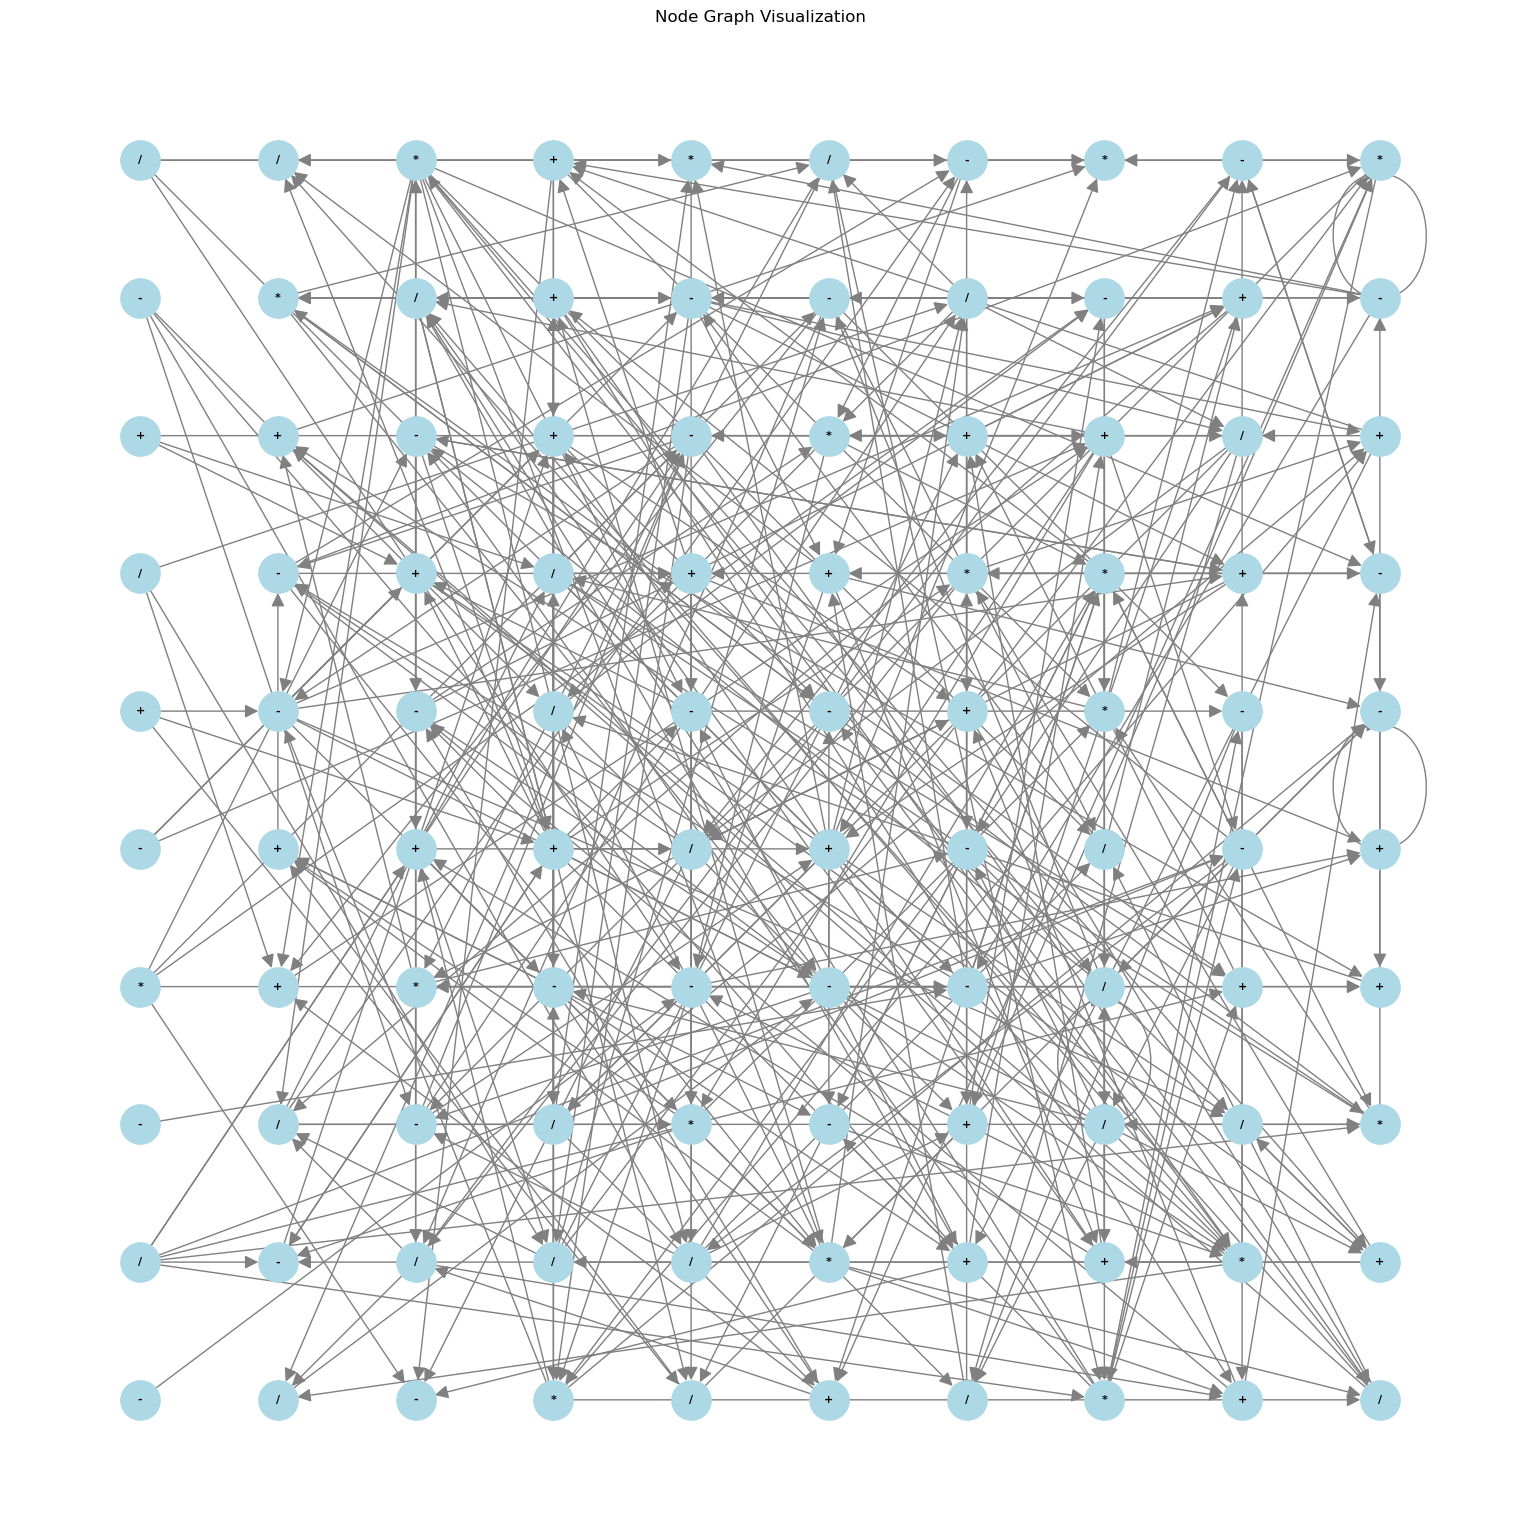

In [120]:
import networkx as nx
import matplotlib.pyplot as plt

nodes = decode_nodes(arr.flatten())

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for node in nodes:
    node_id = f"N{node.x}_{node.y}"
    G.add_node(node_id, function=op_dict[node.function], pos=(node.x, -node.y))

# Add edges based on connections between nodes
for node in nodes:
    node_id = f"N{node.x}_{node.y}"
    
    # Connect inputs (each node can have up to 4 inputs)
    inputs = [(node.input0x, node.input0y), (node.input1x, node.input1y), 
              (node.input2x, node.input2y), (node.input3x, node.input3y)]
    
    for input_x, input_y in inputs:
        input_node_id = f"N{input_x}_{input_y}"
        if input_node_id in G.nodes():
            G.add_edge(input_node_id, node_id)

# Set up positions and labels for visualization
pos = nx.get_node_attributes(G, 'pos')
labels = {node: G.nodes[node]['function'] for node in G.nodes()}

# Create the plot
plt.figure(figsize=(15, 15))
nx.draw(G, pos, labels=labels, node_color='lightblue', 
        node_size=800, font_size=8, font_weight='bold', 
        arrows=True, arrowsize=20, edge_color='gray')
plt.title("Node Graph Visualization")
plt.show()